# Low rank approximation of BEM matrices with adaptive cross approximation (ACA).

In the last section, I demonstrated how to avoid constructing the full dense BEM matrix by regenerating matrix entries whenever they are needed. This can be helpful for reducing memory costs and, in some situations, actually results in a faster solver too. But, it still suffers from the fundamental problem of having to work with a dense matrix where each matrix-vector product is an $O(n^2)$ operation. Ultimately, for boundary integral methods to be a useful technology, we need to avoid working with dense matrices entirely. 

So, here, I'll be demonstrating how the off-diagonal blocks of a BEM matrix can be dramatically compressed via a low-rank approximation. The result will be $O(n\log n)$ or $O(n)$ solution methods that can scale up to millions of elements. Hierarchical matrices (aka H-matrices,{cite:p}`Bebendorf2008`), tree-codes {cite:p}`Barnes1986`, fast multipole methods (FMM, {cite:p}`beatson1997short`) and several other techniques all make use of this basic concept. I'd argue these linear or log-linear methods are the largest distinguishing factor between "basic" BEM approaches from "advanced" or "modern" BEM approaches. So, let's dive into a tour of low rank matrices! The tools we build here will form the core of the hierarchical matrix (H-matrix) implementation in the next section.

To start out, let's generate, yet again, a simple self-interaction matrix for a free surface. For simplicity, I just used a triangulated planar rectangle rather than anything realistic. I hid these cells since the code is nothing new.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

import cutde

In [2]:
surf_L = 4000
n_els_per_dim = 50

mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
surf_pts = np.array([mesh_xg, mesh_yg, 0 * mesh_yg]).reshape((3, -1)).T.copy()

surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i : i + 2]
        y1, y2 = mesh_ys[j : j + 2]
        surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
        surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])

surf_tris = np.array(surf_tris, dtype=np.int64)
surf_tri_pts = surf_pts[surf_tris]
surf_centroids = np.mean(surf_tri_pts, axis=1)

surf_surf_mat = cutde.disp_matrix(
    surf_centroids + np.array([0, 0, 0.01]), surf_pts[surf_tris], 0.25
)

lhs_reordered = np.empty_like(surf_surf_mat)
lhs_reordered[:, :, :, 0] = surf_surf_mat[:, :, :, 1]
lhs_reordered[:, :, :, 1] = surf_surf_mat[:, :, :, 0]
lhs_reordered[:, :, :, 2] = surf_surf_mat[:, :, :, 2]
lhs_reordered = lhs_reordered.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
lhs_reordered += np.eye(lhs_reordered.shape[0])

A = lhs_reordered

## Near-field vs far-field

Let's dig in and investigate the matrix itself! In particular, let's start by looking at two blocks of the matrix. 
1. A "near-field" block will contain the diagonal of the matrix. Remember that the diagonal of the matrix consists of entries representing the displacement at the center of the same element on which the slip occurred. You can see the bright yellow diagonal in the figure below. The matrix entries decay rapidly away from the diagonal. 
2. The other, a "far-field" block will consist of matrix entries coming from interactions between observation points and source elements that are very far from each other. In the figure below, there's no intense variation in entries. 

The thing to notice here is that there is, in some sense, just a lot more going on in the near-field matrix.

<ipython-input-3-38c45f4a2f2b>:5: RuntimeWarning: invalid value encountered in log10
  log_near = np.log10(near_field_block)
<ipython-input-3-38c45f4a2f2b>:7: RuntimeWarning: invalid value encountered in log10
  log_far = np.log10(far_field_block)


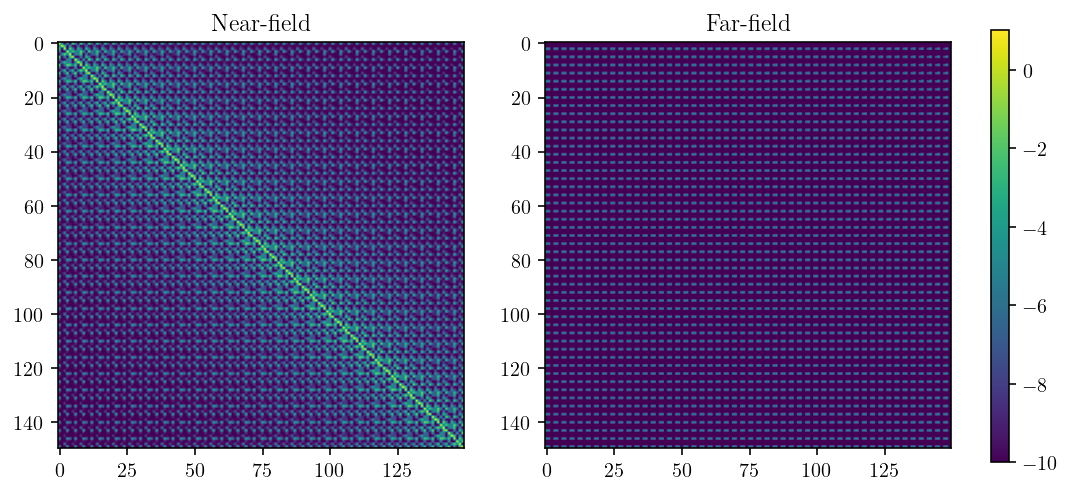

In [3]:
nrows = 150
near_field_block = A[:nrows, :nrows]
far_field_block = A[-nrows:, :nrows]

log_near = np.log10(near_field_block)
log_near[np.isnan(log_near)] = -10
log_far = np.log10(far_field_block)
log_far[np.isnan(log_far)] = -10

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(log_near, vmin=-10, vmax=1)
plt.title("Near-field")
plt.subplot(1, 2, 2)
ims = plt.imshow(log_far, vmin=-10, vmax=1)
plt.title("Far-field")
cbar_ax = fig.add_axes([0.935, 0.125, 0.015, 0.75])
cb = fig.colorbar(ims, cax=cbar_ax)
plt.show()

Another way of visualizing this same "a lot going on" property would be to look at the action of the matrix. So, we'll apply both the nearfield and far-field blocks to a vector with random elements. The difference is striking: the output from the near-field matrix preserves the "randomness" of the input whereas the far-field matrix actually smooths out the input dramatically.

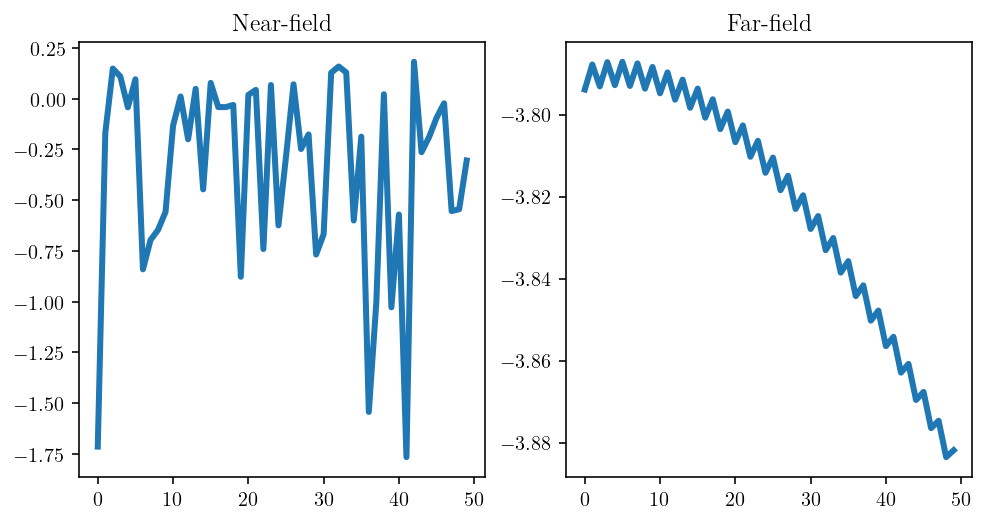

In [4]:
x = np.random.rand(nrows)
y1 = near_field_block.dot(x)
y2 = far_field_block.dot(x)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log10(np.abs(y1[2::3])))
plt.title("Near-field")
plt.subplot(1, 2, 2)
plt.plot(np.log10(np.abs(y2[2::3])))
plt.title("Far-field")
plt.show()

A third and more rigorous way of discussing this same property is to look at the singular values of the two matrix blocks.

In [5]:
U_near, S_near, V_near = np.linalg.svd(near_field_block)
U_far, S_far, V_far = np.linalg.svd(far_field_block)

The plot below shows the $\log_{10}$ ratio of each singular value to the first singular value. Things to note here:
* The near-field singular values do not decay. They are almost all between 1.58 and 1.41. This reflects the behavior above where the randomness of the `x` vector was mostly preserved.
* The far-field singular values decay very quickly. The majority of the singular values are smaller than 1e-6. In other words, the matrix has a "1e-6 approximate rank" of 14 despite technically have a rank of 150. That means that if we only care about accuracy up to about 6 digits, then we can compress this matrix by about a factor of 6.

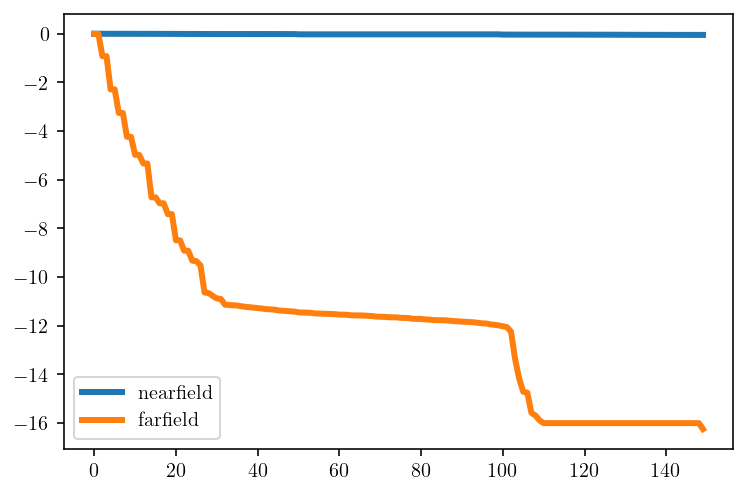

In [6]:
plt.plot(np.log10(S_near / S_near[0]), label="nearfield")
plt.plot(np.log10(S_far / S_far[0]), label="farfield")
plt.legend()
plt.show()

The 14th far-field singular value is below 1e-6.

In [7]:
S_far[14] / S_far[0]

1.8980941903866048e-07

## Approximation with the singular value decomposition (SVD)

So, if these off-diagonal blocks of the matrix have singular values that decay quite quickly, can we approximate these blocks with just a few singular values? The answer is an emphatic yes and this idea is the basis of low-rank approximation methods. Let's explore this idea a bit more with a larger 3000x3000 block coming the lower left corner of the matrix. Because it's also off-diagonal, this block shows the same singular value magnitude decay that we saw before.

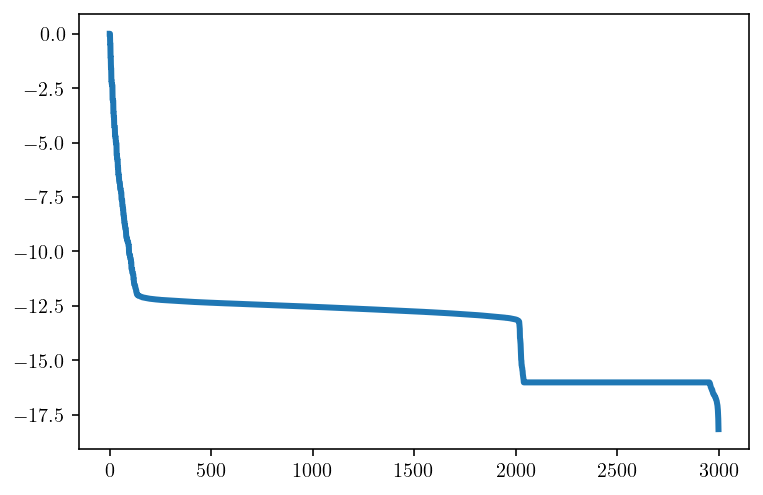

In [8]:
block = A[-3000:, :3000]
U, S, V = np.linalg.svd(block)

plt.plot(np.log10(S / S[0]))
plt.show()

To continue, it's useful to define what the relevant metric for the matrix approximation that we're going to do. A useful norm is the Frobenius norm because it depends only on the matrix entries and for a matrix $M \in \mathbb{R}^{n x m}$ is defined as:
\begin{equation}
\|M\|_F = \sqrt{\sum_{i,j}^{m,n} M_{ij}^2}
\end{equation}
An important fact is that the Frobenius norm of a matrix is the root of the sum of the square of the singular values. That is:
\begin{equation}
\|M\|_F = \sqrt{\sum_{k}^{min(m,n)} \sigma_k^2}
\end{equation}

So, what if we want to approximate a matrix with a particular tolerance, $\epsilon$ in terms of the Frobenius norm? One way to do it will be to compute the SVD and then find the lowest index $K$ for which the constraint is true:
\begin{equation}
\sqrt{\sum_{k=1}^K \sigma_k^2} - \|M\|_F = \sqrt{\sum_{k=K}^{min(m,n)} \sigma_k^2} < \epsilon
\end{equation}

The middle sum from $K$ to the number of rows/columns is essentially a measure of how important the dropped singular values are. So we want that sum to be smaller than our tolerance! The actual implementation below is surprisingly simple.

Here, I'll choose $\epsilon = 10^{-8}$. As demonstrated below, we only need the first 40 singular values to compute such an approximation, meaning that we can store the left and right singular vectors in matrices of shape `(3000, 40)`. This will compress the matrix by a factor of 37.5x!

In [9]:
eps = 1e-8
eps

1e-08

In [10]:
# Reverse the list of singular values and sum them to compute the
# error from each level of truncation.
frob_K = np.sqrt(np.cumsum(S[::-1] ** 2))[::-1]

appx_rank = np.argmax(frob_K < eps)
appx_rank

40

In [11]:
frob_K

array([1.03496590e-02, 7.73331069e-03, 3.53462239e-03, ..., 2.62094754e-20, 1.47210395e-20, 4.74891493e-21])

And let's take a look at the performance and error resulting from applying this low rank approximation to a random vector. First, I'll create an random input vector `x`. Then, I'll form two matrices `Uappx` and `Vappx`. You can sort of think of these as the entrance and exit to our low-dimensional space. This low-dimensional space allows for a very computationally efficient representation of the TDE interactions. Mutliplying `Vappx` by the 3000-dimensional `x` returns a 40-dimensional vector and then we expand back to 3000 dimensional by multiplying by `Uappx`.

In [12]:
Uappx = U[:, :appx_rank]
Vappx = S[:appx_rank, None] * V[:appx_rank]

Next, I'll calculate the correct matrix vector product, `y_true = block.dot(x)` and record the runtime.

In [13]:
x = np.random.rand(block.shape[1])

In [14]:
full_time = %timeit -o block.dot(x)
y_true = block.dot(x)

16.2 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


And then, calculate the low-rank matrix vector product, `y_appx` and record the runtime.

In [15]:
lowrank_time = %timeit -o Uappx.dot(Vappx.dot(x))
y_appx = Uappx.dot(Vappx.dot(x))

118 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


A cursory comparison of the output suggests that the approximation is very very accurate.

In [16]:
print(y_true[:5], y_appx[:5])

[ 0.00158663 -0.00311533  0.00137562  0.00160553 -0.00318513] [ 0.00158663 -0.00311533  0.00137562  0.00160553 -0.00318513]


And the calculation is far, far faster!!

In [17]:
speedup = full_time.best / lowrank_time.best
memory_reduction = block.nbytes / (Uappx.nbytes + Vappx.nbytes)
print(f"speed up         = {speedup}")
print(f"memory reduction = {memory_reduction}")

speed up         = 136.39205663226505
memory reduction = 37.5


Let's do a bit more detailed investigation of the error and look at the $L^1$, $L^2$ and $L^{\infty}$ relative error in the matrix vector product. We'll also compare the Frobenius norm of the approximated matrix with the Frobenius norm of the original matrix.

In [18]:
abs_true = np.abs(y_true)
l2_true = np.mean(abs_true)
l1_true = np.mean(abs_true)
linf_true = np.max(abs_true)

abs_diff = np.abs(y_appx - y_true)
l2_err = np.sqrt(np.mean(abs_diff ** 2)) / l2_true
l1_err = np.mean(abs_diff) / l1_true
linf_err = np.max(abs_diff) / linf_true
true_frob = np.sqrt(np.sum(block ** 2))
frob_err = np.sqrt(np.sum((Uappx.dot(Vappx) - block) ** 2))
print(f"L1(UVx-y)        = {l1_err}")
print(f"L2(UVx-y)        = {l2_err}")
print(f"Linf(UVx-y)      = {linf_err}")
print(f"Frobenius(M-UV)  = {frob_err}")

L1(UVx-y)        = 1.3584158548259891e-08
L2(UVx-y)        = 2.136392527914555e-08
Linf(UVx-y)      = 8.650815624055714e-08
Frobenius(M-UV)  = 8.902174079271246e-09


It looks like this SVD approximation worked out really well here! We're getting very low error matrix-vector products. These errors are all somewhat similar to threshold we used for the singular value cutoff. And, based on the Frobenius error, the approximate matrix itself is extremely similar to the original matrix. The Frobenius error is just barely better than our tolerance condition, as expected. 

Before we move on, I'll record these error values in a dataframe so that it's easy to compare with the fancier methods in the next two sections.

In [19]:
err_df = pd.DataFrame(
    index=["Rank", "L2(UVx-y)", "L1(UVx-y)", "Linf(UVx-y)", "Frobenius(M-UV)"],
    data=dict(true=[block.shape[0], 0, 0, 0, 0]),
)
err_df["SVD"] = [appx_rank, l2_err, l1_err, linf_err, frob_err]

In [20]:
err_df.T

,Rank,L2(UVx-y),L1(UVx-y),Linf(UVx-y),Frobenius(M-UV)
true,3000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SVD,40.0,2.136393e-08,1.358416e-08,8.650816e-08,8.902174e-09


## Adaptive cross approximation (ACA)

So, we've managed to create an extremely efficient approximation of our off-diagonal matrix block by using the SVD. That's definitely useful for computing fast matrix-vector products or even for computing a LU decomposition. But, it still suffers from the need to compute the entire matrix block in the first place, an $O(n^2)$ operation! If we're going to be throwing all that information away immediately after computing the SVD, is there a way to avoid computing the dense matrix block in the first place? There are several solutions to this problem like randomized SVDs {cite:p}`Halko2011`, but the most useful solution for our setting is the adaptive cross approximation (ACA) method {cite:p}`Bebendorf2000, bebendorf2003adaptive`. These algorithms depending on the ability to compute arbitrary individual matrix entries without computing the entire matrix. By making certain assumptions about the structure of a matrix, we can be confident that an accurate approximation can be constructed from just a few rows and columns. 

The basic idea of ACA is to approximate a matrix with a rank 1 outer product of one row and one column of that same matrix. And then iteratively use this process to construct an approximation of arbitrary precision. Ideally, at each step, we will choose the best fitting row and column. After the first iteration, we are no longer trying to approximate the original matrix, but instead we approximate the residual matrix formed by the difference between the original matrix and the current approximation matrix. Eventually, given certain matrix properties that have been proven true for BEM problem  {cite:p}`bebendorf2003adaptive`, the procedure will converge. 

For the sake of real-world usage, the description above will be sufficient for understanding what's going on. But, if you want to dive into a detailed description and implementation of the method, see below! Otherwise, skip over the next two sub-sections.

### ACA and ACA+, the details
The simple version, runs like (following {cite:t}`Grasedyck2004`):

**ACA with full pivoting**: Given a matrix $M \in \mathbb{R}^{n x m}$, we'll construct an approximation like $\sum_{k}^{r} u_k v_k^T$. The task will be to construct the row and column vectors $u_k$ and $v_k$ on each iteration such that the Frobenius norm error eventually converges. To do that, the key will be to iteratively form rank-1 approximations to the residual matrix. The residual matrix is the matrix forming the difference between $M$ and the current approximation and can be written as $R_{ij} = M_{ij} - \sum_{k}^{r} u_{kj} v_{ki}$ representing the entry-wise difference between the target matrix and the current approximation. The goal will be to have $R$ satisfy $\|R\|_2 < \epsilon$ where $\epsilon$ is a user-specified accuracy parameter. To do this, during each iteration:
1. Determine a "pivot" $(i^*, j^*)$ as the indices that maximize $R_{ij}$. Intuitively, the largest rows and columns are going to be most "important".
2. Assign a new rank-1 component of the approximation: 

    \begin{align}
    u_{kj} &= R_{i^*,j} / R_{i^*,j^*} \\
    v_{ki} &= R_{i,j^*}
    \end{align}
3. Update $R$ to account for the new rank-1 update to the approximation. 
4. If the magnitude of the $u_k v_k$ update is small enough, stop. Otherwise, return to step 1.

The reason the algorithm is called "ACA with full pivoting" is because we're allowing the algorithm to choose an arbitrary $(i^*, j^*)$ in the first step. However, that is impossible in our real-world setting because it requires full knowledge of the residual matrix. But, we don't have all the entries of $M$ so we can't have all the entries of $R_{ij}$. Computing all the entries of $M$ is exactly what we're trying to avoid! But, this basic "full information" algorithm is instructive and can be modified slightly so that we don't need the whole matrix.

**ACA+**: Most real-world application use either *ACA with partial pivoting* or the *ACA+* ("ACA plus") algorithm. Here, I'll introduce the modifications necessary for ACA+. The main distinction is that instead of searching over all matrix indices in step 1, we will search over a subset specified by a random row and a random row. This row and column will be our window into the matrix. Instead of finding the largest entry across the full pivoting algorithm in step 1, we will just find the largest entry in either the row window or the column window. While the ACA+ approximation will be less efficient and will converge more slowly than ACA with full pivoting, the end result will still be very good. Note that this approach may completely fail for general low rank matrices, but is very successful for the low rank matrices specifically coming from BEM problems. 

The algorithm: Before starting the iteration, we choose a random row, $i_{\mathrm{ref}}$ and random $j_{\mathrm{ref}}$. And we will maintain the corresponding row and column of the residual matrix, $R$. At the start of the algorithm $R_{i_{\mathrm{ref}}, j} = M_{i_{\mathrm{ref}}, j}$ and $R_{i, j_{\mathrm{ref}}} = M_{i, _{\mathrm{ref}}j}$ 

Then, the iteration proceeds like:
1. Find the index $j^*$ that maximizes $R_{i_{\mathrm{ref}}, j}$ and the index $i^*$ that maximizes $R_{i, j_{\mathrm{ref}}}$. Essentially, we are finding the largest entries in each of these vectors. 
2. If $R_{i_{\mathrm{ref}}, j^*} > R_{i^*, j_{\mathrm{ref}}}$ then, we compute the column corresponding to $j^*$ or if the opposite is true, we compute the row corresponding to $i^*$. Essentially, we are determining here whether we should pivot first based on the row or the column. 
3. If we pivoted based on column, we should now have computed a new residual column $R_{i,j^*} = M_{i,j^*} - \sum_{k}^{r} u_{kj^*} v_{ki}$. Find the missing pivot index now by maximizing $R_{i,j^*}$ to get $i^*$. Or if we pivoted on the row, we will have a new residual row $R_{i^*,j} = M_{i^*,j} - \sum_{k}^{r} u_{kj} v_{ki^*}$ and we maximize $R_{i^*,j}$ to get $j^*$. The idea here is to finish the pivot operation from step 2 by pivoting in the dimension that we have not considered yet. At each step, we are essentially trying to find the largest residual matrix element out of all the entries we have seen so far with the goal of getting as close as possible to the full pivoting algorithm without actually needing to calculate all the residual matrix elements. Why am I referring to the identification of the largest entries as "pivoting"? This is by analogy to various matrix operations like LU decomposition where the numerical stability is best when the largest entries are handled first. ACA can also be reframed as an iterative triangular decomposition of a matrix. Before moving on, note how we calculate the residual row (column) here by computing the original matrix row and then subtracting the row (column) of the current approximation. This is critical since it means that we're only compunting a single row or column of the original matrix. 
4. Next, just like in the full pivoting algorithm, assign: 

    \begin{align}
    u_{kj} &= R_{i^*,j} / R_{i^*,j^*} \\
    v_{ki} &= R_{i,j^*}
    \end{align}
5. And update the $R_{i_{\mathrm{ref}}, j}$ row and $R_{i, j_{\mathrm{ref}}}$ by subtracting the new terms of the approximation.
6. Finally, if the magnitude of the $u_k v_k$ update is small enough, stop. Otherwise, return to step 1.

I hope the key difference with the full pivoting algorithm is now clear -- we only need to compute a single row and a single column of the matrix for each iteration. If the algorithm converges in a number of iterations less than the rank of the matrix $M$, then we will have computed only a small subset of the entries. I've deliberately left some of the details vague in order to make the salient features of the algorithm more prominent. But, below, I'm going to go through a full implementation of the algorithm so hopefully that will clear up any of the details. 

### Implementing ACA+

An implementation of ACA+ is below. I've put lots of comments throughout to help explain the details. But, if you don't want to dive into the details here, just skip over this section.

In [21]:
def ACA_plus(n_rows, n_cols, calc_rows, calc_cols, eps, max_iter=None, verbose=False):
    """
    Run the ACA+ plus algorithm on a matrix implicitly defined by the
    row and column computation functions passed as arguments.

    :param n_rows:
    :param n_cols:
    :param calc_rows: A function that accepts two parameters (Istart, Iend)
        specifying the first and last row desired and returns a numpy array
        with shape (Iend-Istart, N_col) with the corresponding rows of the
        input matrix
    :param calc_cols: A function that accepts two parameters (Jstart, Jend)
        specifying the first and last column desired and returns a numpy array
        with shape (N_rows, Jend-Jstart) with the corresponding columns of the
        input matrix
    :param eps: The tolerance of the approximation. The convergence condition is
        in terms of the difference in Frobenius norm between the target matrix
        and the approximation
    :param max_iter:
    :param verbose: Should we print information at each iteration. Just included
        for demonstration here.

    :return U_ACA: The left-hand approximation matrix.
    :return V_ACA: The right-hand approximation matrix.
    """

    us = []  # The left vectors of the approximation
    vs = []  # The right vectors of the approximation
    prevIstar = []  # Previously used i^* pivots
    prevJstar = []  # Previously used j^* pivots

    # a quick helper function that will help find the largest entry in
    # an array while excluding some list of `disallowed`  entries.
    def argmax_not_in_list(arr, disallowed):
        arg_sorted = arr.argsort()
        max_idx = arg_sorted.shape[0] - 1
        while True:
            if arg_sorted[max_idx] in disallowed:
                max_idx -= 1
            else:
                break
        return arg_sorted[max_idx]

    # A function that will return a contiguous block of rows of the
    # residual matrix
    def calc_residual_rows(Istart, Iend):
        # First calculate the rows of the original matrix.
        out = calc_rows(Istart, Iend).copy()
        # Then subtract the current terms of the approximation
        for i in range(len(us)):
            out -= us[i][Istart:Iend][:, None] * vs[i][None, :]
        return out

    # See above, except this function calculates a block of columns.
    def calc_residual_cols(Jstart, Jend):
        out = calc_cols(Jstart, Jend).copy()
        for i in range(len(us)):
            out -= vs[i][Jstart:Jend][None, :] * us[i][:, None]
        return out

    # A function for finding a reference row and updating
    # it with respect to the already constructed approximation.
    def reset_reference_row(Iref):
        # When a row gets used in the approximation, we will need to
        # reset to use a different reference row. Just, increment!
        while True:
            Iref = (Iref + 3) % n_rows
            Iref -= Iref % 3
            if Iref not in prevIstar:
                break

        # Grab the "row" (actually three rows corresponding to the
        # x, y, and z components for a single observation point)
        return calc_residual_rows(Iref, Iref + 3), Iref

    # Same function as above but for the reference column
    def reset_reference_col(Jref):
        while True:
            Jref = (Jref + 3) % n_cols
            Jref -= Jref % 3
            if Jref not in prevJstar:
                break

        return calc_residual_cols(Jref, Jref + 3), Jref

    # If we haven't converged before running for max_iter, we'll stop anyway.
    if max_iter is None:
        max_iter = np.min([n_rows, n_cols])
    else:
        max_iter = np.min([n_rows, n_cols, max_iter])

    # Create a buffer for storing the R_{i^*,j} and R_{i, j^*}
    RIstar = np.zeros(n_cols)
    RJstar = np.zeros(n_rows)

    # Choose our starting random reference row and column.
    # These will get incremented by 3 inside reset_reference_row
    # so pre-subtract that.
    Iref = np.random.randint(n_rows) - 3
    Jref = np.random.randint(n_cols) - 3
    # And collect the corresponding blocks of rows/columns
    RIref, Iref = reset_reference_row(Iref)
    RJref, Jref = reset_reference_col(Jref)

    for k in range(max_iter):
        # These two lines find the column in RIref with the largest entry (step 1 above).
        maxabsRIref = np.max(np.abs(RIref), axis=0)
        Jstar = argmax_not_in_list(maxabsRIref, prevJstar)

        # And these two find the row in RJref with the largest entry (step 1 above).
        maxabsRJref = np.max(np.abs(RJref), axis=1)
        Istar = argmax_not_in_list(maxabsRJref, prevIstar)

        # Check if we should pivot first based on row or based on column (step 2 above)
        Jstar_val = maxabsRIref[Jstar]
        Istar_val = maxabsRJref[Istar]
        if Istar_val > Jstar_val:
            # If we pivot first on the row, then calculate the corresponding row
            # of the residual matrix.
            RIstar[:] = calc_residual_rows(Istar, Istar + 1)[0]

            # Then find the largest entry in that row vector to identify which
            # column to pivot on. (See step 3 above)
            Jstar = argmax_not_in_list(np.abs(RIstar), prevJstar)

            # Calculate the corresponding residual column!
            RJstar[:] = calc_residual_cols(Jstar, Jstar + 1)[:, 0]
        else:
            # If we pivot first on the column, then calculate the corresponding column
            # of the residual matrix.
            RJstar[:] = calc_residual_cols(Jstar, Jstar + 1)[:, 0]

            # Then find the largest entry in that row vector to identify which
            # column to pivot on.  (See step 3 above)
            Istar = argmax_not_in_list(np.abs(RJstar), prevIstar)

            # Calculate the corresponding residual row!
            RIstar[:] = calc_residual_rows(Istar, Istar + 1)[0]

        # Record the pivot row and column so that we don't re-use them.
        prevIstar.append(Istar)
        prevJstar.append(Jstar)

        # Add the new rank-1 outer product to the approximation (see step 4 above)
        vs.append(RIstar / RIstar[Jstar])
        us.append(RJstar.copy())

        # How "large" was this update to the approximation?
        step_size = np.sqrt(np.sum(us[-1] ** 2) * np.sum(vs[-1] ** 2))
        if verbose:
            print(
                f"pivot row={Istar:4d}, pivot col={Jstar:4d}, "
                f"step size={step_size:1.3e}, "
                f"tolerance={eps:1.3e}"
            )

        # The convergence criteria will simply be whether the Frobenius norm of the
        # step is smaller than the user provided tolerance.
        if step_size < eps:
            break

        # We also break here if this is the last iteration to avoid wasting effort
        # updating the reference row/column
        if k == max_iter - 1:
            break

        # If we didn't converge, let's prep the reference residual row and
        # column for the next iteration:

        # If we pivoted on the reference row, then choose a new reference row.
        # Remember that we are using a x,y,z vector "row" or
        # set of 3 rows in an algebraic sense.
        if Iref <= Istar < Iref + 3:
            RIref, Iref = reset_reference_row(Iref)
        else:
            # If we didn't change the reference row of the residual matrix "R",
            # update the row to account for the new components of the approximation.
            RIref -= us[-1][Iref : Iref + 3][:, None] * vs[-1][None, :]

        # If we pivoted on the reference column, then choose a new reference column.
        # Remember that we are using a x,y,z vector "column" or
        # set of 3 columns in an algebraic sense.
        if Jref <= Jstar < Jref + 3:
            RJref, Jref = reset_reference_col(Jref)
        else:
            # If we didn't change the reference column of the residual matrix "R",
            # update the column to account for the new components of the approximation.
            RJref -= vs[-1][Jref : Jref + 3][None, :] * us[-1][:, None]

    # Return the left and right approximation matrices.
    # The approximate is such that:
    # M ~ U_ACA.dot(V_ACA)
    U_ACA = np.array(us).T
    V_ACA = np.array(vs)

    return U_ACA, V_ACA

## ACA+ is accurate and efficient

And let's demonstrate the algorithm on the same block we used to demonstrate the SVD compression method. One note here: I set the error tolerance to `eps / 50.0` because the error tolerance from the ACA algorithm is imprecise. The factor of 50 is large enough to be very confident that the error will be less than or equal to `eps`. We'll see in the next section how to get a tighter tolerance.

In [22]:
U_ACA, V_ACA = ACA_plus(
    block.shape[0],
    block.shape[1],
    lambda Istart, Iend: block[Istart:Iend, :],
    lambda Jstart, Jend: block[:, Jstart:Jend],
    eps / 50.0,
    verbose=True,
)

pivot row=  41, pivot col=2737, step size=4.769e-03, tolerance=2.000e-10
pivot row=  40, pivot col=2738, step size=4.775e-03, tolerance=2.000e-10
pivot row= 233, pivot col=2923, step size=4.011e-03, tolerance=2.000e-10
pivot row= 232, pivot col=2924, step size=4.015e-03, tolerance=2.000e-10
pivot row= 298, pivot col=2999, step size=5.662e-04, tolerance=2.000e-10
pivot row= 119, pivot col=2827, step size=7.059e-04, tolerance=2.000e-10
pivot row=1502, pivot col=2700, step size=2.034e-04, tolerance=2.000e-10
pivot row= 130, pivot col=2834, step size=5.521e-04, tolerance=2.000e-10
pivot row=   3, pivot col=2102, step size=1.604e-04, tolerance=2.000e-10
pivot row= 299, pivot col= 298, step size=4.521e-04, tolerance=2.000e-10
pivot row=2999, pivot col=2995, step size=8.867e-05, tolerance=2.000e-10
pivot row= 297, pivot col= 299, step size=8.282e-05, tolerance=2.000e-10
pivot row=2701, pivot col= 125, step size=1.288e-04, tolerance=2.000e-10
pivot row=2810, pivot col=2997, step size=1.189e-04

pivot row=2754, pivot col=2804, step size=1.362e-08, tolerance=2.000e-10
pivot row= 106, pivot col=2309, step size=1.312e-08, tolerance=2.000e-10
pivot row=2952, pivot col=  57, step size=6.764e-09, tolerance=2.000e-10


pivot row= 287, pivot col= 124, step size=4.520e-09, tolerance=2.000e-10
pivot row= 147, pivot col=2087, step size=2.711e-09, tolerance=2.000e-10
pivot row= 688, pivot col= 197, step size=2.474e-09, tolerance=2.000e-10


pivot row= 820, pivot col=2144, step size=1.887e-09, tolerance=2.000e-10
pivot row= 746, pivot col=2893, step size=2.752e-09, tolerance=2.000e-10
pivot row= 662, pivot col=2179, step size=1.335e-09, tolerance=2.000e-10
pivot row= 302, pivot col=2719, step size=8.310e-10, tolerance=2.000e-10
pivot row=2960, pivot col=2317, step size=1.885e-09, tolerance=2.000e-10
pivot row=1197, pivot col= 505, step size=1.719e-09, tolerance=2.000e-10
pivot row= 285, pivot col=1331, step size=1.314e-09, tolerance=2.000e-10
pivot row= 201, pivot col=2948, step size=4.831e-10, tolerance=2.000e-10
pivot row=1200, pivot col=2234, step size=9.550e-10, tolerance=2.000e-10
pivot row=  15, pivot col=1817, step size=7.290e-10, tolerance=2.000e-10
pivot row=2558, pivot col=   4, step size=6.145e-10, tolerance=2.000e-10
pivot row=2044, pivot col=2756, step size=3.284e-10, tolerance=2.000e-10
pivot row=1902, pivot col=1014, step size=3.726e-10, tolerance=2.000e-10
pivot row=  95, pivot col=2892, step size=3.491e-10

In [23]:
U_ACA.shape

(3000, 72)

Clearly, the process is converging. We've produced an accurate approximation with a rank of 72. You can see the step sizes are converging at almost the rate we would expect from the graph of singular value magnitudes above. As we'll see below, the ACA+ algorithm is achieving similar levels of accuracy to the SVD with only about 50% more rows and columns.

First, let's check the accuracy of this matrix approximation by looking at the error from a matrix-vector product.

In [24]:
y_aca = U_ACA.dot(V_ACA.dot(x))

In [25]:
abs_diff = np.abs(y_aca - y_true)
l2_err = np.sqrt(np.mean(abs_diff ** 2)) / l2_true
l1_err = np.mean(abs_diff) / l1_true
linf_err = np.max(abs_diff) / linf_true
frob_err = np.sqrt(np.sum((U_ACA.dot(V_ACA) - block) ** 2))
print(f"L1(UVx-y)        = {l1_err}")
print(f"L2(UVx-y)        = {l2_err}")
print(f"Linf(UVx-y)      = {linf_err}")
print(f"frob error(M-UV) = {frob_err}")

err_df["ACA"] = [U_ACA.shape[1], l2_err, l1_err, linf_err, frob_err]

L1(UVx-y)        = 3.626367457060864e-09
L2(UVx-y)        = 5.128173154798858e-09
Linf(UVx-y)      = 1.1389902758171598e-08
frob error(M-UV) = 3.2135004521183193e-10


Looking great! We specified the tolerance as `eps` for both ACA+ and for the SVD. ACA overshot a little and is giving accuracy substantially better than the SVD. This is because of the lower tolerance we passed. Due to the inherent randomness in the algorithm, sometimes ACA+ won't overshoot quite as much. Either way, for a confident tolerance with ACA+ we need to overshoot a little bit because ACA+ is using only local information from the current iteration to decide when to stop whereas the SVD is able to be absolutely certain about the singular values.

In [26]:
terms = []
l1_mvp_errs = []
frob_errs = []
for i in range(500):
    U, V = ACA_plus(
        block.shape[0],
        block.shape[1],
        lambda Istart, Iend: block[Istart:Iend, :],
        lambda Jstart, Jend: block[:, Jstart:Jend],
        eps / 50.0,
        verbose=False,
    )
    terms.append(U.shape[1])
    y_aca = U.dot(V.dot(x))
    l1_mvp_errs.append(np.mean(np.abs(y_aca - y_true)) / l1_true)
    frob_errs.append(np.sqrt(np.sum((U.dot(V) - block) ** 2)))

Before moving on, I wanted to demonstrate that the randomness inherent in the reference row/column selection in the ACA+ algorithm is not affecting the end result. See below for histograms showing the distribution of the number of approximation terms and the $L^1$ matrix-vector error of the approximate matrix. As you can see, ACA+ is producing consistent results within a small range of rank. The matrix-vector error is also consistently and acceptably good. The Frobenius error is also 5-50x below the tolerance specified.

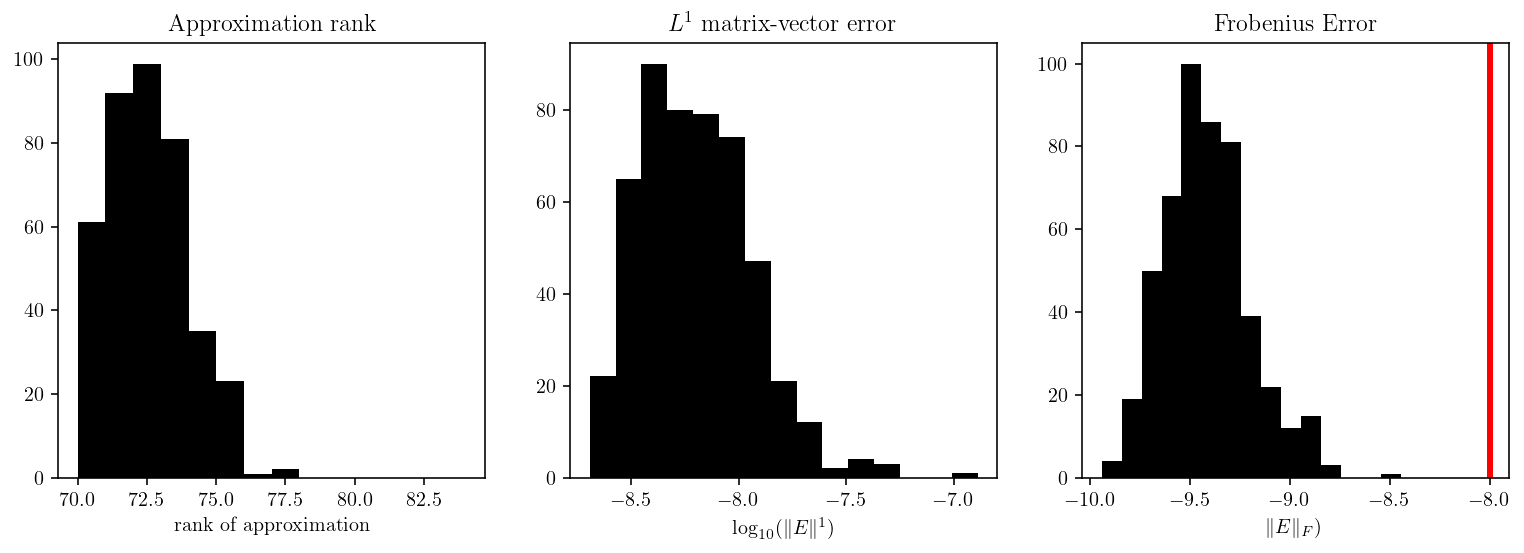

In [27]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.title("Approximation rank")
plt.hist(terms, bins=np.arange(70, 85), color="k")
plt.xlabel("rank of approximation")
plt.subplot(1, 3, 2)
plt.title("$L^1$ matrix-vector error")
plt.hist(np.log10(l1_mvp_errs), bins=15, color="k")
plt.xlabel("$\log_{10}(\|E\|^1)$")
plt.subplot(1, 3, 3)
plt.title("Frobenius Error")
plt.hist(np.log10(frob_errs), bins=15, color="k")
plt.gca().axvline(np.log10(eps), color="r")
plt.xlabel("$\|E\|_{F})$")
plt.show()

### SVD Recompression

In some sense, the approximation we built with ACA is too good. Most of the time, we're getting Frobenius errors much lower than we asked for. But there's some inconsistency in the output error. This inconsistency is why we asked for `eps/50.0` as the convergence criterion. However, we would ideally want an algorithm that *juuust barely* meets the tolerance condition. Unfortunately that's quite difficult when the algorithm is stuck with limited information about the matrix under consideration. So, in this final section I'll demonstrate a simple post-processing method that will reduce the size/cost of the approximation to more precisely fit the requested tolerance.

The basic idea is quite simple: just do another compression of the ACA approximation matrices with the singular value decomposition. We wanted to avoid doing an SVD on the original full-size matrix block, but now that we have constructed a reduced expression, it can be worthwhile to do the extra effort to reduce it even further with an exact SVD.

How do we do that? I've already built an approximation that looks like:
\begin{equation}
M \approx UV^T
\end{equation}
Basically $V^T$ maps from a high-dimensional space to a low-dimensional space and then $U$ maps back from the low-dimensional space to the high-dimensional space. So, let's first extract the low-dimensional operation. To do that, perform a QR decomposition on both $U$ and $V$. Then we have:
\begin{equation}
UV^T = Q_UR_UR_V^TQ_V^T
\end{equation}
One way of thinking about this is that $Q_V^T$ and $Q_U$ are just rotations now and $R_UR_V^T$ is a square matrix in the low-dimensional subspace that is performing the non-rotational action of $M$. 

Now, take the SVD of that small action matrix:
\begin{equation}
R_UR_V^T = W \Sigma Z^T
\end{equation}

And we'll filter on the singular values in $\Sigma$ to reduce the rank of the matrix just like we did before with the full SVD. That's it! To reconstruct the approximation, we just need:
\begin{align}
\overline{U} &= Q_UW\Sigma \\
\overline{V} &= ZQ_V \\
M &\approx \overline{U}\overline{V}^T
\end{align}

The transformation into code is super straightforward!

In [28]:
QU, RU = np.linalg.qr(U_ACA)
QV, RV = np.linalg.qr(V_ACA.T)
W, SIG, Z = np.linalg.svd(RU.dot(RV.T))

In [29]:
# Reverse the list of singular values and sum them to compute the
# error from each level of truncation.
frob_K = np.sqrt(np.cumsum(SIG[::-1] ** 2))[::-1]
r = np.argmax(frob_K < eps)
r
print(f"Recompressing from rank {SIG.shape[0]} to rank {r}")

Recompressing from rank 72 to rank 40


In [30]:
U_ACA2 = QU.dot(W[:, :r] * SIG[:r])
V_ACA2 = Z[:r, :].dot(QV.T)

Just seven lines of code to recompress by almost a factor of 2! This will make later matrix-vector products almost twice as fast.

In [31]:
y_aca_2 = U_ACA2.dot(V_ACA2.dot(x))

In [32]:
abs_diff = np.abs(y_aca_2 - y_true)
l2_err = np.sqrt(np.mean(abs_diff ** 2)) / l2_true
l1_err = np.mean(abs_diff) / l1_true
linf_err = np.max(abs_diff) / linf_true
frob_err = np.sqrt(np.sum((U_ACA2.dot(V_ACA2) - block) ** 2))
print(f"L1(UVx-y)        = {l1_err}")
print(f"L2(UVx-y)        = {l2_err}")
print(f"Linf(UVx-y)      = {linf_err}")
print(f"frob error(M-UV) = {frob_err}")

err_df["Recompress"] = [U_ACA2.shape[1], l2_err, l1_err, linf_err, frob_err]

L1(UVx-y)        = 1.4319261271868302e-08
L2(UVx-y)        = 2.187121549956022e-08
Linf(UVx-y)      = 8.809720307948416e-08
frob error(M-UV) = 8.906540993272918e-09


As you can see in the table below, the amazing thing here is that ACA and then SVD recompression can recover a matrix approximation that is almost exactly as good as the compression that is computed using a direct SVD. The error in the table between the "SVD" and "Recompress" is shockingly close.

In [33]:
err_df.T

,Rank,L2(UVx-y),L1(UVx-y),Linf(UVx-y),Frobenius(M-UV)
true,3000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SVD,40.0,2.136393e-08,1.358416e-08,8.650816e-08,8.902174e-09
ACA,72.0,5.128173e-09,3.626367e-09,1.138990e-08,3.213500e-10
Recompress,40.0,2.187122e-08,1.431926e-08,8.809720e-08,8.906541e-09


And to finish this section, I'll repeat this process many times to demonstrate that the randomness of the ACA+ does not affect the ability of the SVD recompression to produce almost exactly the same approximation  every time!

In [34]:
def SVD_recompress(U_ACA, V_ACA, eps):
    """
    Recompress an ACA matrix approximation via SVD.

    :param U_ACA: The left-hand approximation matrix.
    :param V_ACA: The right-hand approximation matrix.
    :param eps: The tolerance of the approximation. The convergence condition is
        in terms of the difference in Frobenius norm between the target matrix
        and the approximation.

    :return U_SVD: The SVD recompressed left-hand approximation matrix.
    :return V_SVD: The SVD recompressed right-hand approximation matrix.
    """
    UQ, UR = np.linalg.qr(U_ACA)
    VQ, VR = np.linalg.qr(V_ACA.T)
    W, SIG, Z = np.linalg.svd(UR.dot(VR.T))

    frob_K = np.sqrt(np.cumsum(SIG[::-1] ** 2))[::-1]
    r = np.argmax(frob_K < eps)

    U = UQ.dot(W[:, :r] * SIG[:r])
    V = Z[:r, :].dot(VQ.T)
    return U, V

In [35]:
terms = []
l1_mvp_errs = []
frob_errs = []
for i in range(50):
    U, V = ACA_plus(
        block.shape[0],
        block.shape[1],
        lambda Istart, Iend: block[Istart:Iend, :],
        lambda Jstart, Jend: block[:, Jstart:Jend],
        eps / 50.0,
        verbose=False,
    )
    U, V = SVD_recompress(U, V, eps)
    terms.append(U.shape[1])
    y_aca = U.dot(V.dot(x))
    l1_mvp_errs.append(np.mean(np.abs(y_aca - y_true)) / l1_true)
    frob_errs.append(np.sqrt(np.sum((U.dot(V) - block) ** 2)))

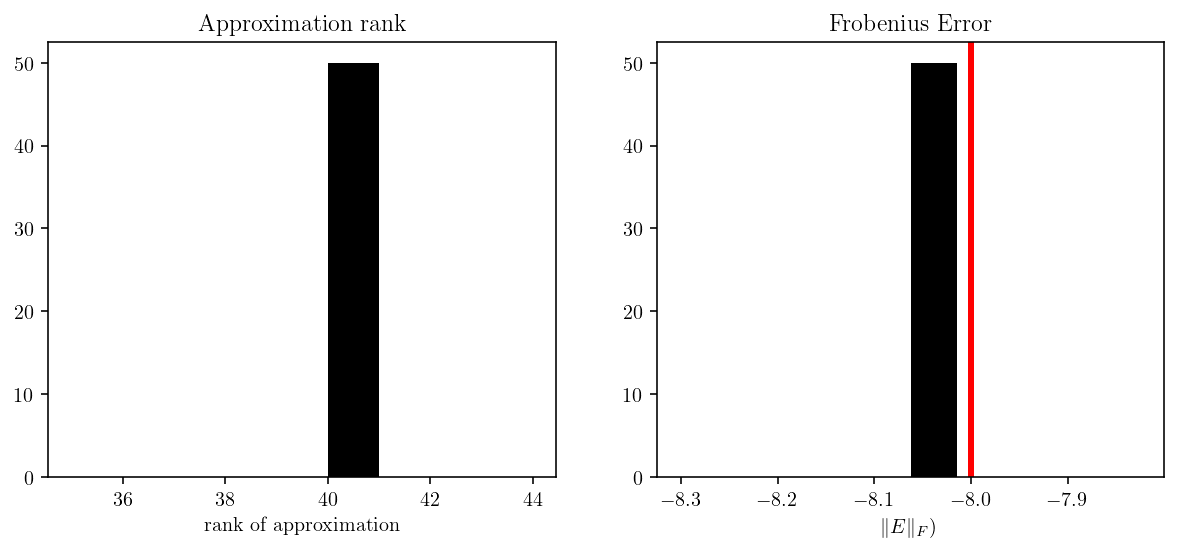

In [36]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Approximation rank")
plt.hist(terms, bins=np.arange(35, 45), color="k")
plt.xlabel("rank of approximation")
plt.subplot(1, 2, 2)
plt.title("Frobenius Error")
plt.hist(
    np.log10(frob_errs),
    bins=np.linspace(np.log10(eps * 0.5), np.log10(eps * 1.5), 11),
    color="k",
)
plt.gca().axvline(np.log10(eps), color="r")
plt.xlabel("$\|E\|_{F})$")
plt.show()

I think it's worth stopping for a moment to appreciate how cool math can be. We started from an algorithm that involves both some randomness and a severe lack of information on the matrix being approximated. And from that algorithm, we've built an almost perfectly consistent algorithm for producing a precise approximate matrix. In the SVD recompressed results, there's exactly zero variation in the rank and almost zero variation in the error. And the error is just barely on the correct side of the tolerance!